In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf

sns.set_style('whitegrid')

# Setting the parameters

In [3]:
ticker = 'INTC'
start_date = '2019-01-01'
end_date = '2023-12-31'

# These are the moving average windows
ma_short = 50
ma_long = 200

# We will adjust our positions based on the past 20-day volatility
vol_lookback = 20

# We set a stop-loss threshold of 15% the entry price
stop_loss_pct = 0.15

initial_capital = 100000

# We assume transaction costs of 1%. These include things like 
# commissions, slippage, bid-ask spread, and other kinds of trading costs      
transaction_costs = 0.01

# Data Retrieval

In [4]:
df = yf.download(ticker, start=start_date, end=end_date)
df = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].dropna()

[*********************100%***********************]  1 of 1 completed


# Feature Engineering

In [5]:
df['Returns'] = df['Adj Close'].pct_change()

df['MA_Short'] = df['Adj Close'].rolling(ma_short).mean()
df['MA_Long'] = df['Adj Close'].rolling(ma_long).mean()

# This is used only for dynamic position sizing
df['Volatility'] = df['Returns'].rolling(vol_lookback).std(ddof=0)

# Signal: 1 if MA_Short > MA_Long, -1 if MA_Short < MA_Long, 0 otherwise
df['Signal'] = 0
df.loc[df['MA_Short'] > df['MA_Long'], 'Signal'] = 1
df.loc[df['MA_Short'] < df['MA_Long'], 'Signal'] = -1

# We shift signals by 1 day to avoid lookahead bias
df['Signal'] = df['Signal'].shift(1)

# This is for our volatility-based position sizing
risk_fraction = 0.01  # risk 1% of capital per trade
df['Position_Size'] = np.nan

# Backtest

In [6]:
df['Position'] = 0.0       # how many shares we actually hold
df['Cash'] = 0.0           # how much cash we hold
df['Equity'] = 0.0         # total equity = cash + position * price
df['Trade_Price'] = np.nan # price at which we entered the trade
df['Stop_Loss'] = np.nan   # stop-loss price

capital = initial_capital
position = 0
entry_price = 0
stop_loss = 0

In [7]:
for i in range(len(df)):
    price = df['Adj Close'].iloc[i]
    
    if i == 0:
        # On the first day we initialise as follows
        df.at[df.index[i], 'Cash'] = capital
        df.at[df.index[i], 'Position'] = 0
        df.at[df.index[i], 'Equity'] = capital
        continue
    
    # This retrieves yesterday's equity, position, and cash
    prev_equity = df['Equity'].iloc[i-1]
    prev_position = df['Position'].iloc[i-1]
    prev_cash = df['Cash'].iloc[i-1]
    
    signal = df['Signal'].iloc[i]
    vol = df['Volatility'].iloc[i]

    # We compute today's position size (in number of shares) based on yesterday's equity
    if vol == 0 or np.isnan(vol):
        position_size = prev_position
    else:
        position_size = (risk_fraction * prev_equity) / (vol * price)
    
    # Here we implement our stop-loss
    if prev_position != 0:
        # If we're long and price < stop_loss, we exit
        if prev_position > 0 and price < stop_loss:
            signal = 0
        # If we're short and price > stop_loss, we exit
        if prev_position < 0 and price > stop_loss:
            signal = 0

    # Here we implement the trading logic
    if signal == 1:
        # If we are not already long, we go long
        if prev_position <= 0:
            # 1) Close any short positions first
            realized_pnl = 0
            if prev_position < 0:
                # Closing short => buy back shares
                # Number of shares to buy back = abs(prev_position)
                # PnL from the short = (Entry_Price - Current_Price) * abs(Position)
                shares_to_buy = abs(prev_position)
                close_amount = shares_to_buy * price
                commission_closing = close_amount * transaction_costs
                realized_pnl = (prev_position * (price - df['Trade_Price'].iloc[i-1]))
                prev_cash = prev_cash + realized_pnl - commission_closing
            
            # 2) Open the new long
            new_position = position_size
            cost = new_position * price
            commission_opening = cost * transaction_costs
            total_outflow = cost + commission_opening
            
            if total_outflow > prev_cash:
                new_position = (prev_cash / (price * (1 + transaction_costs)))
                cost = new_position * price
                commission_opening = cost * transaction_costs
                total_outflow = cost + commission_opening
            
            new_cash = prev_cash - total_outflow
            entry_price = price
            stop_loss = price * (1 - stop_loss_pct)
            position = new_position
        
        else:
            # If we are already long, we don't do anything
            new_cash = prev_cash
            position = prev_position
            entry_price = df['Trade_Price'].iloc[i-1]
            stop_loss = df['Stop_Loss'].iloc[i-1]
    
    elif signal == -1:
        # If we are not already short, we go short
        if prev_position >= 0:
            # 1) Close any long positions first
            realized_pnl = 0
            if prev_position > 0:
                # Sell the shares
                shares_to_sell = prev_position
                sell_amount = shares_to_sell * price
                commission_closing = sell_amount * transaction_costs
                realized_pnl = (prev_position * (price - df['Trade_Price'].iloc[i-1]))
                prev_cash = prev_cash + realized_pnl - commission_closing
            
            # 2) Open new short
            new_position = -position_size
            proceeds = abs(new_position) * price
            commission_opening = proceeds * transaction_costs
            total_inflow = proceeds - commission_opening
            
            new_cash = prev_cash + total_inflow
            entry_price = price
            stop_loss = price * (1 + stop_loss_pct)
            position = new_position
        
        else:
            # In case we are already short, we don't do anything
            new_cash = prev_cash
            position = prev_position
            entry_price = df['Trade_Price'].iloc[i-1]
            stop_loss = df['Stop_Loss'].iloc[i-1]
    
    else:
        # if the signal is 0, we want to be flat
        # If we have a position, close it
        if prev_position != 0:
            if prev_position > 0:
                # We sell all shares at current price
                sell_amount = prev_position * price
                commission_close = sell_amount * transaction_costs
                realized_pnl = prev_position * (price - df['Trade_Price'].iloc[i-1])
                new_cash = prev_cash + realized_pnl - commission_close
            else:
                # We buy back short
                shares_to_buy = abs(prev_position)
                buy_amount = shares_to_buy * price
                commission_close = buy_amount * transaction_costs
                realized_pnl = prev_position * (price - df['Trade_Price'].iloc[i-1])
                new_cash = prev_cash + realized_pnl - commission_close
            position = 0
            entry_price = np.nan
            stop_loss = np.nan
        else:
            # We remain flat
            new_cash = prev_cash
            position = prev_position
            entry_price = df['Trade_Price'].iloc[i-1]
            stop_loss = df['Stop_Loss'].iloc[i-1]
    
    df.at[df.index[i], 'Position'] = position
    df.at[df.index[i], 'Trade_Price'] = entry_price
    df.at[df.index[i], 'Stop_Loss'] = stop_loss
    df.at[df.index[i], 'Cash'] = new_cash
    
    equity = new_cash + position * price
    df.at[df.index[i], 'Equity'] = equity

# Performance Metrics

In [8]:
df['Equity_Change'] = df['Equity'].pct_change().fillna(0)
df['Strategy_Returns'] = df['Equity_Change']
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod() - 1

final_equity = df['Equity'].iloc[-1]
total_pnl = final_equity - initial_capital
pct_gain = total_pnl / initial_capital

daily_return_mean = df['Strategy_Returns'].mean()
daily_return_std = df['Strategy_Returns'].std(ddof=1)

sharpe_ratio = (daily_return_mean / daily_return_std) * np.sqrt(252)

negative_returns = df['Strategy_Returns'][df['Strategy_Returns'] < 0]
downside_std = negative_returns.std(ddof=1)
sortino_ratio = (daily_return_mean / downside_std) * np.sqrt(252)

num_days = (df.index[-1] - df.index[0]).days
years = num_days / 365.25
cagr = (final_equity / initial_capital)**(1/years) - 1

df['RollingMax'] = df['Equity'].cummax()
df['Drawdown'] = df['Equity'] / df['RollingMax'] - 1
max_drawdown = df['Drawdown'].min()

calmar_ratio = (cagr) / abs(max_drawdown)

# Plotting Results

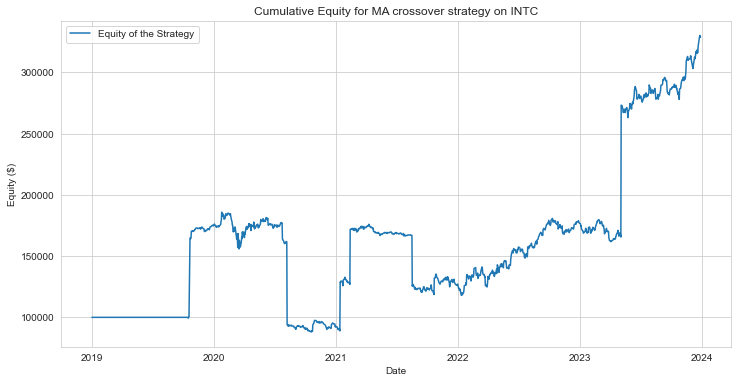

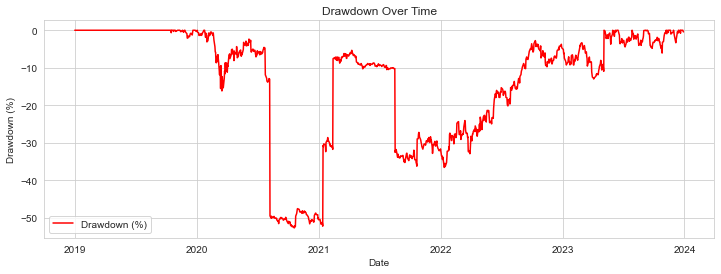

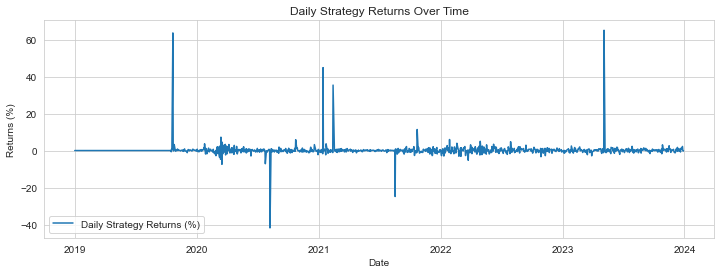

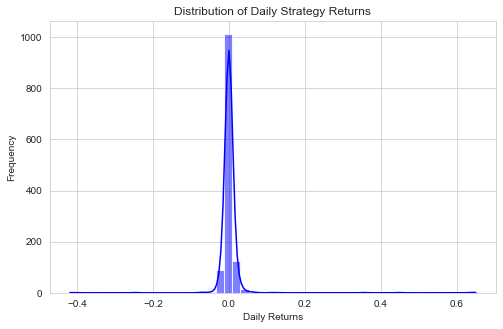

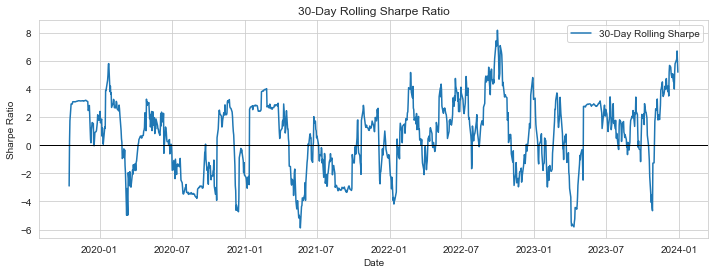

In [9]:
# Plot the equity resulting from the strategy
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Equity'], label='Equity of the Strategy')
plt.title(f'Cumulative Equity for MA crossover strategy on {ticker}')
plt.xlabel('Date')
plt.ylabel('Equity ($)')
plt.legend()
plt.show()

# Plot the drawdown
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Drawdown'] * 100, color='red', label='Drawdown (%)')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.show()

# Plot daily strategy returns over time
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Strategy_Returns']*100, label='Daily Strategy Returns (%)')
plt.title('Daily Strategy Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()
plt.show()

# Distribution of daily returns
plt.figure(figsize=(8, 5))
sns.histplot(df['Strategy_Returns'], bins=50, kde=True, color='blue')
plt.title('Distribution of Daily Strategy Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

# Rolling Sharpe ratio (computed with a 30-day window)
roll_window = 30
df['RollMean'] = df['Strategy_Returns'].rolling(roll_window).mean()
df['RollStd'] = df['Strategy_Returns'].rolling(roll_window).std(ddof=1)
df['Rolling_Sharpe'] = (df['RollMean'] / df['RollStd']) * np.sqrt(252)

plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Rolling_Sharpe'], label=f'{roll_window}-Day Rolling Sharpe')
plt.axhline(0, color='black', linewidth=1)
plt.title(f'{roll_window}-Day Rolling Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()

In [10]:
print(f"Ticker: {ticker}")
print(f"Period: {start_date} to {end_date}")
print(f"MA Short: {ma_short}, MA Long: {ma_long}")
print(f"Transaction costs: {transaction_costs*100:.2f}% per trade")
print(f"Final Equity: ${final_equity:,.2f}")
print(f"Total PnL: ${total_pnl:,.2f}")
print(f"Gain: {pct_gain*100:,.2f}%")
print(f"Daily Mean Return: {daily_return_mean*100:.3f}%")
print(f"Daily Std Dev: {daily_return_std*100:.3f}%")
print(f"Annualised Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"CAGR: {cagr*100:.2f}%")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")

Ticker: INTC
Period: 2019-01-01 to 2023-12-31
MA Short: 50, MA Long: 200
Transaction costs: 1.00% per trade
Final Equity: $328,676.81
Total PnL: $228,676.81
Gain: 228.68%
Daily Mean Return: 0.147%
Daily Std Dev: 3.495%
Annualised Sharpe Ratio: 0.67
Sortino Ratio: 1.04
CAGR: 26.91%
Calmar Ratio: 0.51
Max Drawdown: -52.63%
